In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import random
from openai import OpenAI
import os

# Constants
mode = 'user'
method = np.dot
n_recommendations = 12
n_candidates = 19
length_limit = 8
random_seed = 2023
api_key = os.getenv("OPENAI_API_KEY")
model = "gpt-3.5-turbo"

client = OpenAI(api_key=api_key)

In [6]:
random.seed(random_seed)

def read_json(file):
    with open(file) as f:
        return json.load(f)

# Reading data file:
dataset = read_json("ml_100k.json")

movies_map = {}
distinct_movies = []
hit_list = []
max_watch = 0
for elem in dataset:
    watched = elem[0].split(' | ')
    max_watch = max(max_watch, len(watched))
    for movie in watched:
        if movie not in movies_map:
            movies_map[movie] = len(movies_map)
            distinct_movies.append(movie)
n_movies = len(movies_map)
print("Number of different movies: ", n_movies)
print("Max movies watched: ", max_watch)

Number of different movies:  1493
Max movies watched:  50


In [7]:
class CollaborativeFiltering:
    """
    Collaborative Filtering class for User-User or Item-Item predictions.
    """
    def __init__(self, method=method, mode=mode) -> None:
        """
        Initialize the collaborative filtering model.
        
        Parameters:
        - method: similarity function
        - mode: 'user' for User-User CF, 'item' for Item-Item CF
        """
        self.method = method
        self.mode = mode
        self.S = None # Similarity matrix

    def fit(self) -> None:
        """
        Compute the similarity matrix.
        """
        if self.mode == 'user':
            print("Computing User-User CF Similarity Matrix...")
            user_list = []
            for elem in dataset:
                watched_list = [0 for _ in range(n_movies)]
                watched = elem[0].split(' | ')
                for movie in watched:
                    watched_list[movies_map[movie]] = 1
                user_list.append(watched_list)
            user_matrix = np.array(user_list)
            self.S = self.method(user_matrix, user_matrix.T)
        else:  # mode == 'item'
            print("Computing Item-Item CF Similarity Matrix...")
            movie_list = [[0. for _ in range(len(dataset))] for _ in range(n_movies)]
            for i, elem in enumerate(dataset):
                movies = elem[0].split(' | ')
                for movie in movies:
                    movie_list[movies_map[movie]][i] = 1
            item_matrix = np.array(movie_list)
            self.S = self.method(item_matrix, item_matrix.T)
            
        # np.fill_diagonal(self.S, 0)

    def recommend(self, userid: int):
        watched = dataset[userid][0].split(' | ')
        movies_score = {}
        if self.mode == 'user':
            similariests = sorted(list(enumerate(self.S[userid])), key=lambda x:x[-1], reverse=True)[:n_recommendations]
            dvd = sum([e[-1] for e in similariests])
            for other_userid, similarity in similariests:
                weight = similarity / dvd
                other_watched = dataset[other_userid][0].split(' | ')
                for movie in other_watched:
                    if movie not in watched:
                        if movie not in movies_score:
                            movies_score[movie] = 0.
                        movies_score[movie] += weight
            candidate_pairs = list(sorted(movies_score.items(), key=lambda x:x[-1], reverse=True))
            candidate_items = [e[0] for e in candidate_pairs][:n_candidates]
        else:  # mode == 'item'
            for movie in watched:
                similariests = sorted(list(enumerate(self.S[movies_map[movie]])), key=lambda x: x[-1], reverse=True)[:n_recommendations]
                for movieid, weight in similariests:
                    other_movie = distinct_movies[movieid]
                    if other_movie not in watched:
                        if other_movie not in movies_score:
                            movies_score[other_movie] = 0.
                        movies_score[other_movie] += weight
            candidate_pairs = list(sorted(movies_score.items(), key=lambda x:x[-1], reverse=True))
            candidate_items = [e[0] for e in candidate_pairs][:n_candidates]
        return candidate_items
    
    def evaluate_hit_rate(self, status: bool) -> float:
        """
        Evaluate Hit Rate@N for the CF model.
        """
        if status == True:
            if self.mode == 'user':
                print("Computing HR@10 using User-User CF...")
            else:  # mode == 'item'
                print("Computing HR@10 using Item-Item CF...")
        hits = 0
        total = len(dataset)
        for user_id, elem in enumerate(tqdm(dataset)):
            recommended = self.recommend(user_id)
            if elem[-1] in recommended:
                hits += 1
                hit_list.append(user_id)
        return hits / total

In [8]:
# User-User CF
cf_user = CollaborativeFiltering(mode='user')
cf_user.fit()
print(cf_user.evaluate_hit_rate(True))
print(f"Hit list: {hit_list}")

# Item-Item CF
# cf_item = CollaborativeFiltering(mode='item')
# cf_item.fit()
# print(cf_item.evaluate_hit_rate(True))

Computing User-User CF Similarity Matrix...
Computing HR@10 using User-User CF...


100%|██████████| 943/943 [00:00<00:00, 1429.78it/s]

0.18663838812301167
Hit list: []


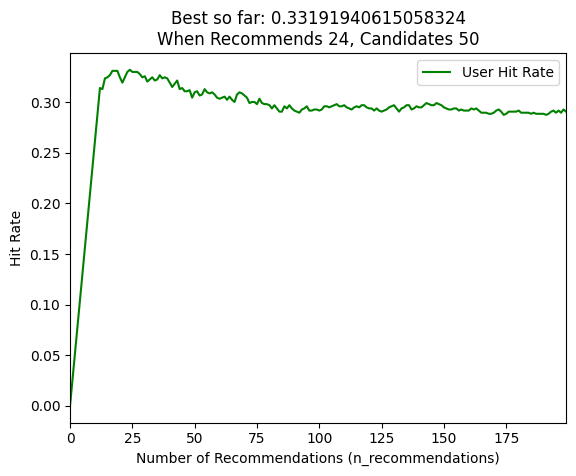

In [9]:
# import matplotlib.pyplot as plt
# from IPython.display import clear_output

# plt.ion()  # Turn on interactive mode

# # Initialize plot
# fig, ax = plt.subplots()
# plt.show()

# # Finding the best n_recommendations and n_candidates
# for i in range(50, 51, 1):
#     x, y_u = [0], [0]
#     n_candidates = i
#     maxu, id = 0, 0
#     for j in range(12, 200, 1):
#         n_recommendations = j
#         hruu = cf_user.evaluate_hit_rate(False)

#         x.append(j)
#         y_u.append(hruu)
        
#         clear_output(wait=True)  # Clear the output for the next update
#         plt.clf() # Clear the previous plot
        
#         # Plot y_u and y_i
#         plt.plot(x, y_u, color='g', label='User Hit Rate')
        
#         # Set plot limits
#         plt.xlim(x[0], x[-1])
        
#         # Add titles and labels
#         plt.title(f"Best so far: {maxu}\nWhen Recommends {id}, Candidates {i}")
#         plt.xlabel("Number of Recommendations (n_recommendations)")
#         plt.ylabel("Hit Rate")
#         filename = f"{i}_candidates.png"
#         plt.savefig(filename)
        
#         # Add legend
#         plt.legend()

#         plt.pause(0.5)

#         if hruu > maxu:
#             maxu, id = hruu, j

# # Turn off interactive mode after the loop finishes
# plt.ioff()
# plt.show()

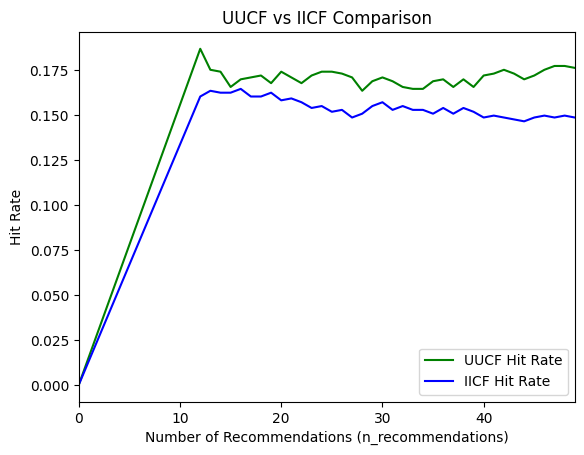

In [14]:
# import matplotlib.pyplot as plt
# from IPython.display import clear_output

# plt.ion()  # Turn on interactive mode

# # Initialize plot
# fig, ax = plt.subplots()
# plt.show()

# # Finding the best n_recommendations and n_candidates
# for i in range(20, 21, 1):
#     x, y_u, y_i = [0], [0], [0]
#     n_candidates = i
#     for j in range(12, 50, 1):
#         n_recommendations = j
#         hruu = cf_user.evaluate_hit_rate(False)
#         hrii = cf_item.evaluate_hit_rate(False)
#         x.append(j)
#         y_u.append(hruu)
#         y_i.append(hrii)
        
#         clear_output(wait=True)  # Clear the output for the next update
#         plt.clf() # Clear the previous plot
        
#         # Plot y_u and y_i
#         plt.plot(x, y_u, color='g', label='UUCF Hit Rate')
#         plt.plot(x, y_i, color='b', label='IICF Hit Rate')
        
#         # Set plot limits
#         plt.xlim(x[0], x[-1])
        
#         # Add titles and labels
#         plt.title(f"UUCF vs IICF Comparison")
#         plt.xlabel("Number of Recommendations (n_recommendations)")
#         plt.ylabel("Hit Rate")
#         filename = f"{i}_candidates_uucf_iicf.png"
#         plt.savefig(filename)
        
#         # Add legend
#         plt.legend()

#         plt.pause(0.5)

# # Turn off interactive mode after the loop finishes
# plt.ioff()
# plt.show()

In [6]:
temp_1 = """
Candidate Set (candidate movies): {}.
The movies I have watched (watched movies): {}.
Step 1: What features are most important to me when selecting movies (Summarize my preferences briefly)? 
Answer: 
"""

temp_2 = """
Candidate Set (candidate movies): {}.
The movies I have watched (watched movies): {}.
Step 1: What features are most important to me when selecting movies (Summarize my preferences briefly)? 
Answer: {}.
Step 2: Selecting the most featured movies from the watched movies according to my preferences in descending order (Format: [no. a watched movie.]).
Answer: 
"""

temp_3 = """
Candidate Set (candidate movies): {}.
The movies I have watched (watched movies): {}.
Step 1: What features are most important to me when selecting movies (Summarize my preferences briefly)? 
Answer: {}.
Step 2: Selecting the most featured movies (at most 5 movies) from the watched movies according to my preferences in descending order (Format: [no. a watched movie.]). 
Answer: {}.
Step 3: Can you recommend 10 movies from the Candidate Set similar to the selected movies I've watched (Format: [no. a watched movie - a candidate movie])?.
Answer: 
"""

In [7]:
def ask_gpt(prompt) -> str:
    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "user",
                "content": prompt,
            },
        ],
        max_tokens=512,
        temperature=0,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        n = 1,
    )
    return response.choices[0].message.content

def gpt_log(prompt, response, i) -> None:
    print(f"Prompt #{i}:\n{prompt}\nResponse:\n{response}\n")
    
# Example with 1st user (index 0)
elem = dataset[0]
seq_list = elem[0].split(' | ')[::-1]

print(f"Watched List: {seq_list}")
print(f"Expected: ", elem[1])

candidate_items = cf_user.recommend(0)
random.shuffle(candidate_items)

input_1 = temp_1.format(', '.join(candidate_items), ', '.join(seq_list[-length_limit:]))
predictions_1 = ask_gpt(input_1)
gpt_log(input_1, predictions_1, 1)

input_2 = temp_2.format(', '.join(candidate_items), ', '.join(seq_list[-length_limit:]), predictions_1)
predictions_2 = ask_gpt(input_2)
gpt_log(input_2, predictions_2, 2)

input_3 = temp_3.format(', '.join(candidate_items), ', '.join(seq_list[-length_limit:]), predictions_1, predictions_2)
predictions = ask_gpt(input_3)
gpt_log(input_3, predictions, 3)

Watched List: ['Strange Days', 'Dazed and Confused', 'The Maltese Falcon', 'French Kiss', 'The Long Kiss Goodnight', 'Amistad', 'Broken Arrow', 'Mars Attacks!', 'Beautiful Girls', 'The Empire Strikes Back', 'Donnie Brasco', 'The Saint', "What's Eating Gilbert Grape", 'Titanic', 'Liar Liar', 'Independence Day (ID4)', "Mr. Holland's Opus", 'The Doors', 'Trainspotting', 'Apocalypse Now', 'Clockwork Orange, A', 'The Full Monty', 'Monty Python and the Holy Grail', "Monty Python's Life of Brian", 'Dances with Wolves', 'The Usual Suspects', 'The Silence of the Lambs', 'Return of the Jedi', 'In the Name of the Father', "One Flew Over the Cuckoo's Nest", 'Indiana Jones and the Last Crusade', 'Aliens', 'Reality Bites', 'Mission: Impossible', 'The Shining', 'The Rock', 'The Craft', 'Scream', 'Kids in the Hall: Brain Candy', 'Kids', 'The Princess Bride', 'Psycho', 'Face/Off', 'The English Patient', "My Best Friend's Wedding"]
Expected:  Starship Troopers
Prompt #1:

Candidate Set (candidate movies

In [8]:
count = 0
total = 0
for i in tqdm(hit_list):
    elem = dataset[i]
    seq_list = elem[0].split(' | ')[::-1]
    
    candidate_items = cf_user.recommend(i)
    random.shuffle(candidate_items)

    input_1 = temp_1.format(', '.join(candidate_items), ', '.join(seq_list[-length_limit:]))
    predictions_1 = ask_gpt(input_1)
    
    input_2 = temp_2.format(', '.join(candidate_items), ', '.join(seq_list[-length_limit:]), predictions_1)
    predictions_2 = ask_gpt(input_2)
    
    input_3 = temp_3.format(', '.join(candidate_items), ', '.join(seq_list[-length_limit:]), predictions_1, predictions_2)
    predictions = ask_gpt(input_3)
    
    if elem[1] in predictions:
        count += 1

    total +=1

print (f'Hit@10 : {count}/{total} = {count*1.0/total}')

100%|██████████| 176/176 [09:43<00:00,  3.32s/it]

Hit@10 : 80/176 = 0.45454545454545453
